In [1]:
import overpy
import pandas as pd
import geopandas as gpd
import xarray as xr
import numpy as np
import rasterio
from rasterio.features import rasterize
import rioxarray
from pathlib import Path
from shapely import LineString,MultiLineString,Polygon,MultiPolygon, Point, GeometryCollection
from shapely.geometry import shape
import shapely
from shapely.ops import polygonize
import requests
import tqdm
import matplotlib.pyplot as plt
import shutil
from itertools import product
import json

In [2]:
blue_band = Path("/home/cyanom/Downloads/S2A_MSIL2A_20230624T104621_N0509_R051_T31TCJ_20230624T182051.SAFE/GRANULE/L2A_T31TCJ_A041804_20230624T105846/IMG_DATA/R10m/T31TCJ_20230624T104621_B02_10m.jp2")
green_band = Path("/home/cyanom/Downloads/S2A_MSIL2A_20230624T104621_N0509_R051_T31TCJ_20230624T182051.SAFE/GRANULE/L2A_T31TCJ_A041804_20230624T105846/IMG_DATA/R10m/T31TCJ_20230624T104621_B03_10m.jp2")
red_band = Path("/home/cyanom/Downloads/S2A_MSIL2A_20230624T104621_N0509_R051_T31TCJ_20230624T182051.SAFE/GRANULE/L2A_T31TCJ_A041804_20230624T105846/IMG_DATA/R10m/T31TCJ_20230624T104621_B04_10m.jp2")
nir_band = Path("/home/cyanom/Downloads/S2A_MSIL2A_20230624T104621_N0509_R051_T31TCJ_20230624T182051.SAFE/GRANULE/L2A_T31TCJ_A041804_20230624T105846/IMG_DATA/R10m/T31TCJ_20230624T104621_B08_10m.jp2")
swir_band = Path("/home/cyanom/Downloads/S2A_MSIL2A_20230624T104621_N0509_R051_T31TCJ_20230624T182051.SAFE/GRANULE/L2A_T31TCJ_A041804_20230624T105846/IMG_DATA/R20m/T31TCJ_20230624T104621_B11_20m.jp2")
target_da = rioxarray.open_rasterio(blue_band)
files = [blue_band, green_band, red_band, nir_band, swir_band]
ds = xr.DataArray(
    data = np.stack(
        [
            rioxarray.open_rasterio(f).rio.reproject_match(target_da).values.squeeze()
            for f in files
        ],
        axis=0
    ),
    coords = {
        "band": ["blue", "green", "red", "nir", "swir"],
        "y": target_da.coords["y"].values,
        "x": target_da.coords["x"].values,
    },
    dims=["band", "y", "x"],
)
ds = ds.rio.write_crs(target_da.rio.crs)
ds

<xarray.DataArray (band: 5, y: 10980, x: 10980)>
array([[[1570, 1594, 1624, ..., 1292, 1258, 1258],
        [1504, 1548, 1544, ..., 1255, 1252, 1250],
        [1490, 1492, 1486, ..., 1235, 1235, 1226],
        ...,
        [1204, 1206, 1217, ..., 1382, 1405, 1445],
        [1190, 1193, 1208, ..., 1413, 1422, 1409],
        [1180, 1180, 1223, ..., 1429, 1425, 1403]],

       [[2008, 2058, 2082, ..., 1568, 1501, 1518],
        [1936, 1982, 1980, ..., 1482, 1477, 1519],
        [1938, 1959, 1916, ..., 1477, 1484, 1482],
        ...,
        [1366, 1367, 1374, ..., 1666, 1706, 1748],
        [1354, 1343, 1373, ..., 1691, 1686, 1672],
        [1368, 1339, 1401, ..., 1732, 1708, 1694]],

       [[1750, 1838, 1893, ..., 1366, 1282, 1294],
        [1662, 1742, 1758, ..., 1291, 1263, 1280],
        [1650, 1688, 1638, ..., 1277, 1256, 1256],
        ...,
        [1184, 1189, 1194, ..., 1852, 1971, 2092],
        [1184, 1192, 1200, ..., 1862, 1912, 1936],
        [1188, 1168, 1196, ..., 1898, 1951, 1921]],

       [[4828, 4748, 4683, ..., 4252, 4296, 4280],
        [4935, 4751, 4760, ..., 4324, 4316, 4255],
        [4919, 4827, 4837, ..., 4315, 4297, 4301],
        ...,
        [5307, 5276, 5164, ..., 3919, 3776, 3811],
        [4584, 4613, 4932, ..., 3976, 3798, 3752],
        [4548, 4608, 5164, ..., 4077, 3852, 3799]],

       [[3310, 3310, 3368, ..., 2834, 2748, 2748],
        [3310, 3310, 3368, ..., 2834, 2748, 2748],
        [3205, 3205, 3219, ..., 2706, 2684, 2684],
        ...,
        [2725, 2725, 2711, ..., 3344, 3486, 3486],
        [2649, 2649, 2740, ..., 3316, 3366, 3366],
        [2649, 2649, 2740, ..., 3316, 3366, 3366]]], dtype=uint16)
Coordinates:
  * band         (band) <U5 'blue' 'green' 'red' 'nir' 'swir'
  * y            (y) float64 4.9e+06 4.9e+06 4.9e+06 ... 4.79e+06 4.79e+06
  * x            (x) float64 3e+05 3e+05 3e+05 ... 4.098e+05 4.098e+05 4.098e+05
    spatial_ref  int64 0

In [3]:
# api = overpy.Overpass()

xmin, ymin, xmax, ymax = ds[:,:,:].rio.transform_bounds("epsg:4326")

bbox = ymin, xmin, ymax, xmax
print(bbox)
center = (ymin + ymax) / 2, (xmin + xmax) / 2
# All of this because an area containing a bbox but not intersecting
# it will not be included in the result.
# query = f"""
#     [out:json];
#     is_in{center};
#     (
#         area._["landuse"];
#         area._["natural"];
#     ) -> .bigarea;
#     (
#         rel(pivot.bigarea);
#         way(pivot.bigarea);
#         rel{bbox}["landuse"];
#         rel{bbox}["natural"];
#         way{bbox}["landuse"];
#         way{bbox}["natural"];
#         way{bbox}["waterway"];
#     );
#     convert item ::=::,::geom=geom(),_osm_type=type();
#     out geom;
# """
query = f"""
    [out:json];
    (
        rel{bbox}["landuse"];
        rel{bbox}["natural"];
        way{bbox}["landuse"];
        way{bbox}["natural"];
        way{bbox}["waterway"];
    );
    out geom;
"""


osm_res = requests.get(url="https://overpass-api.de/api/interpreter", params={'data': query})
osm_res

(43.238262552870076, 0.4959285929146376, 44.2478306835076, 1.8886830141969135)


<Response [200]>

In [4]:
# json.dump(osm_res.json(), open("test.json", "w"), indent=2)

In [5]:
def multipolygon_to_geojson(multipolygon):
    outer_polygons = dict(enumerate(polygonize([
        [(n["lon"], n["lat"]) for n in  member["geometry"]]
        for member in multipolygon["members"]
        if member["role"] == "outer" and member["type"] == "way"
    ])))
    inner_polygons = dict(enumerate(polygonize([
        [(n["lon"], n["lat"]) for n in member["geometry"]]
        for member in multipolygon["members"]
        if member["role"] == "inner" and member["type"] == "way"
    ])))
    outer_inners_map = {ref_outer:[] for ref_outer in outer_polygons.keys()}
    for ref_inner,inner_polygon in inner_polygons.items():
        for ref_outer,outer_polygon in outer_polygons.items():
            if outer_polygon.covers(inner_polygon):
                outer_inners_map[ref_outer].append(ref_inner)
                break
    return {
        "id": multipolygon.get("id", None),
        "geometry": MultiPolygon(
            [
                Polygon(
                    shell=outer_polygon.exterior,
                    holes = [
                        inner_polygons[ref_inner].exterior
                        for ref_inner in outer_inners_map[ref_outer]
                    ]
                )
                for ref_outer,outer_polygon in outer_polygons.items()
            ]
        ),
        **multipolygon.get("tags", {}),
    }

def generic_relation_to_geojson(relation):
    return {
        "id": relation.get("id", None),
        "geometry": GeometryCollection(
            [
                element_to_geojson(element)["geometry"]
                for element in relation["members"]
            ]
        ),
        **relation.get("tags", {}),
    }

def relation_to_geojson(relation):
    if relation.get("tags", {}).get("type", None) == "multipolygon": 
        return multipolygon_to_geojson(relation)
    else:
        return generic_relation_to_geojson(relation)
    raise Exception(f"Unhandled case found in relation {relation}")


def is_way_a_polygon(way: dict) -> bool:
    # Determining if an OSM way is a polygon or not is turbo-crap atm
    # Using heuristic described here: https://wiki.openstreetmap.org/wiki/Overpass_turbo/Polygon_Features
    return way["geometry"][0] == way["geometry"][-1] and way.get("tags", False) and (
        way["tags"].get("area", "no") != "no"
        or way["tags"].get("area:highway", "no") != "no"
        or way["tags"].get("aeroway", "no") not in ["no", "taxiway"]
        or way["tags"].get("amenity", "no") != "no"
        or way["tags"].get("barrier", "no") in ["city_wall", "ditch", "hedge", "retaining_wall", "wall", "spikes"]
        or way["tags"].get("boundary", "no") != "no"
        or way["tags"].get("building:part", "no") != "no"
        or way["tags"].get("building", "no") != "no"
        or way["tags"].get("craft", "no") != "no"
        or way["tags"].get("golf", "no") != "no"
        or way["tags"].get("highway", "no") in ["services", "rest_area", "escape", "elevator"]
        or way["tags"].get("historic", "no") != "no"
        or way["tags"].get("indoor", "no") != "no"
        or way["tags"].get("landuse", "no") != "no"
        or way["tags"].get("leisure", "no") != "no"
        or way["tags"].get("man_made", "no") not in ["no", "cutline", "embankment", "pipeline"]
        or way["tags"].get("military", "no") != "no"
        or way["tags"].get("natural", "no") not in ["no", "coastline", "cliff", "ridge", "arete", "tree_row"]
        or way["tags"].get("office", "no") != "no"
        or way["tags"].get("place", "no") != "no"
        or way["tags"].get("power", "no") in ["plant", "substation", "generator", "transformer"]
        or way["tags"].get("public_transport", "no") != "no"
        or way["tags"].get("railway", "no") in  ["station", "turntable", "roundhouse", "platform"]
        or way["tags"].get("ruins", "no") != "no"
        or way["tags"].get("shop", "no") != "no"
        or way["tags"].get("tourism", "no") != "no"
        or way["tags"].get("waterway", "no") in ["riverbank", "dock", "boatyard", "dam"]
    )

def way_to_geojson(way):
    return {
        "id": way.get("id", None),
        "geometry": [LineString, Polygon][is_way_a_polygon(way)](
            [(n["lon"], n["lat"]) for n in  way["geometry"]]
        ),
        **way.get("tags", {}),
    }

def element_to_geojson(element):
    match element["type"]:
        case "relation":
            return relation_to_geojson(element)
        case "way":
            return way_to_geojson(element)
    raise Exception(f"Unhandled case found in element {element}")


def osm_to_gdf(osm):
    return gpd.GeoDataFrame(
        data=[
            el
            for element in osm["elements"]
            if not (el := element_to_geojson(element))["geometry"].is_empty
        ],
        crs="epsg:4326",
    )

osm_gdf = osm_to_gdf(
    osm_res.json()
)
osm_gdf


/home/cyanom/repositories/city-segmentation/.venv/lib/python3.10/site-packages/shapely/constructive.py:666: RuntimeWarning: invalid value encountered in polygonize
  return lib.polygonize(geometries, **kwargs)


,id,geometry,natural,name,boat,waterway,wikipedia,CEMT,motorboat,water,...,name:ro,name:ru,name:sk,name:sr,name:sv,name:uk,name:zh,region:type,roundtrip,route
0,4357452,"POLYGON ((1.28549 43.52163, 1.28533 43.52164, ...",water,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4357979,"POLYGON ((1.35176 43.56774, 1.35178 43.56799, ...",wood,Bois de La Ramée,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4486801,"LINESTRING (1.43360 43.60252, 1.43406 43.60376)",NaN,NaN,yes,canal,fr:Canal de Brienne,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4486802,"LINESTRING (1.42540 43.61210, 1.42540 43.61210...",NaN,Canal du Midi,yes,canal,NaN,I,yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4533117,"LINESTRING (1.63210 43.62785, 1.63193 43.62789...",NaN,La Sausse,NaN,stream,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96394,16843811,"MULTIPOLYGON (((1.38798 43.47366, 1.38838 43.4...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96395,16888485,"MULTIPOLYGON (((1.48154 43.56582, 1.48185 43.5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96396,16895951,"MULTIPOLYGON (((1.48253 43.56555, 1.48308 43.5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96397,16907784,"MULTIPOLYGON (((1.47615 43.56934, 1.47624 43.5...",water,NaN,NaN,NaN,NaN,NaN,NaN,pond,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
print(set(osm_gdf["landuse"].values))
print(set(osm_gdf["natural"].values))
print(set(osm_gdf["waterway"].values))
osm_gdf[osm_gdf["id"] == 16868177].values


{'cemetery', 'village_green', 'churchyard', 'religious', 'farmland', 'railway', 'military', 'common', 'orchard', 'plant_nursery', 'leisure', 'healthcare', 'education', 'meadow', 'quarry', 'landfill', 'construction', 'service', 'concrete', 'basin', 'apiary', 'greenfield', 'aquaculture', 'allotments', 'stockage', nan, 'grass', 'asphalte', 'brownfield', 'reservoir', 'retail', 'lac', 'residential', 'flowerbed', 'forest', 'compacted', 'animal_keeping', 'departemental', 'harbour', 'depot', 'highway', 'farmyard', 'industrial', 'recreation_ground', 'vineyard', 'logistics', 'greenhouse_horticulture', 'commercial', 'hedge'}
{'shingle', 'fell', 'beach', 'Circuit Cœur de Gascogne', 'bare_rock', 'shrubbery', 'sand', 'cliff', nan, 'grass', 'grassland', 'heath', 'mountain_range', 'wetland', 'waterfall', 'ridge', 'scrub', 'tree_row', 'earth_bank', 'wood', 'scree', 'water', 'mud'}
{'canal', nan, 'yes', 'boatyard', 'fish_pass', 'dam', 'lock_gate', 'drain', 'mooring', 'lock', 'weir', 'river', 'ditch', 's

array([], shape=(0, 324), dtype=object)

In [7]:
osm_gdf = osm_gdf[["landuse", "natural", "waterway", "water", "geometry"]]

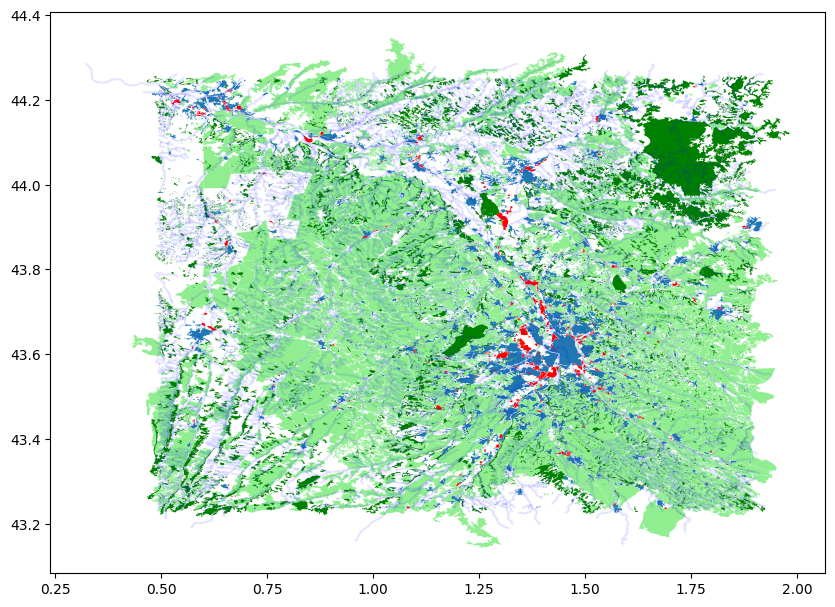

In [8]:
ax = osm_gdf[osm_gdf["landuse"] == "residential"].plot(aspect="equal", figsize=(10, 8))
ax = osm_gdf[osm_gdf["landuse"] == "farmland"].plot(ax=ax, aspect="equal", color="lightgreen")
ax = osm_gdf[osm_gdf["landuse"] == "forest"].plot(ax=ax, aspect="equal", color="green")
ax = osm_gdf[osm_gdf["landuse"] == "industrial"].plot(ax=ax, aspect="equal", color="red")
ax = osm_gdf[osm_gdf["landuse"] == "commercial"].plot(ax=ax, aspect="equal", color="red")
ax = osm_gdf[~osm_gdf["waterway"].isna()].plot(ax=ax, aspect="equal", color="blue", alpha=0.1)

In [9]:
def add_classes(gdf: gpd.GeoDataFrame, func, class_label = "classes") -> gpd.GeoDataFrame:
    gdf.loc[:,class_label] = gdf.apply(func, axis=1)
    return gdf

def create_label_id_map(gdf, class_label = "classes", default_label = "unknown") -> dict:
    labels = set(gdf[class_label].values)
    if default_label in labels:
        labels.remove(default_label)
    return {
        c: i for i,c in enumerate([default_label] + list(labels))
    }

In [67]:
def create_groundtruth_classes_mask(da: xr.DataArray, gdf: gpd.GeoDataFrame, class_label = "classes", label_id_map = None) -> xr.DataArray:
    if label_id_map is None:
        label_id_map = create_label_id_map(gdf)
    labels = list(label_id_map.keys())
    gdf = gdf.sort_values(by=class_label, key= lambda x: [labels.index(d) for d in x.values])
    print(gdf)
    mask = xr.DataArray(
        data = rasterize(
            shapes = [
                (g,c)
                for g,c in 
                zip(gdf["geometry"].to_crs(da.rio.crs), gdf[class_label].map(lambda x: label_id_map[x]))
            ],
            out_shape = da.shape[-2:],
            fill = label_id_map["unknown"],
            transform = da.rio.transform(),
            all_touched = True,
        ),
        coords = (
            da.coords["y"],
            da.coords["x"],
        ),
        dims = da.dims[-2:],
    )
    return mask.rio.set_crs(da.rio.crs).rio.write_crs(da.rio.crs)

In [64]:
def groundtruth_classes(el):
    if el["landuse"] in ["residential", "commercial", "industrial", "cemetery", "education", "construction", "retail", "service", "religious", "churchyard"]:
        return "urban"
    if el["landuse"] == "forest" or el["natural"] == "wood":
        return "forest"
    if el["landuse"] in ["farmland", "vineyard", "orchard"]:
        return "farmland"
    if el["natural"] in ["grassland"]:
        return "grassland"
    if el["natural"] == "water" or el["landuse"] in ["reservoir", "basin", "lac"] or not isinstance(el["waterway"], float):
        return "water"
    return "unknown"

osm_gdf = add_classes(osm_gdf, groundtruth_classes)
osm_gdf[["natural", "landuse", "waterway", "classes"]]

,natural,landuse,waterway,classes
0,water,NaN,NaN,water
1,wood,NaN,NaN,forest
2,NaN,NaN,canal,water
3,NaN,NaN,canal,water
4,NaN,NaN,stream,water
...,...,...,...,...
96394,NaN,farmland,NaN,farmland
96395,NaN,grass,NaN,unknown
96396,NaN,grass,NaN,unknown
96397,water,NaN,NaN,water


In [65]:
label_id_map = create_label_id_map(osm_gdf)
label_id_map = {
    'unknown': 0,
    'farmland': 1,
    'grassland': 2,
    'urban': 3,
    'water': 4,
    'forest': 5
}

             landuse   natural waterway water  \
96398          grass       NaN      NaN   NaN   
83513  village_green       NaN      NaN   NaN   
83514  village_green       NaN      NaN   NaN   
83543         meadow       NaN      NaN   NaN   
83549            NaN  tree_row      NaN   NaN   
...              ...       ...      ...   ...   
46691            NaN      wood      NaN   NaN   
46690            NaN      wood      NaN   NaN   
46685            NaN      wood      NaN   NaN   
21230         forest       NaN      NaN   NaN   
76772         forest       NaN      NaN   NaN   

                                                geometry  classes  
96398  MULTIPOLYGON (((1.46868 43.56150, 1.46868 43.5...  unknown  
83513  POLYGON ((1.24122 44.12860, 1.24125 44.12867, ...  unknown  
83514  POLYGON ((1.24106 44.12870, 1.24115 44.12868, ...  unknown  
83543  POLYGON ((0.65047 43.97206, 0.65062 43.97185, ...  unknown  
83549    LINESTRING (0.66269 43.95634, 0.66143 43.95680)  unknown  
...

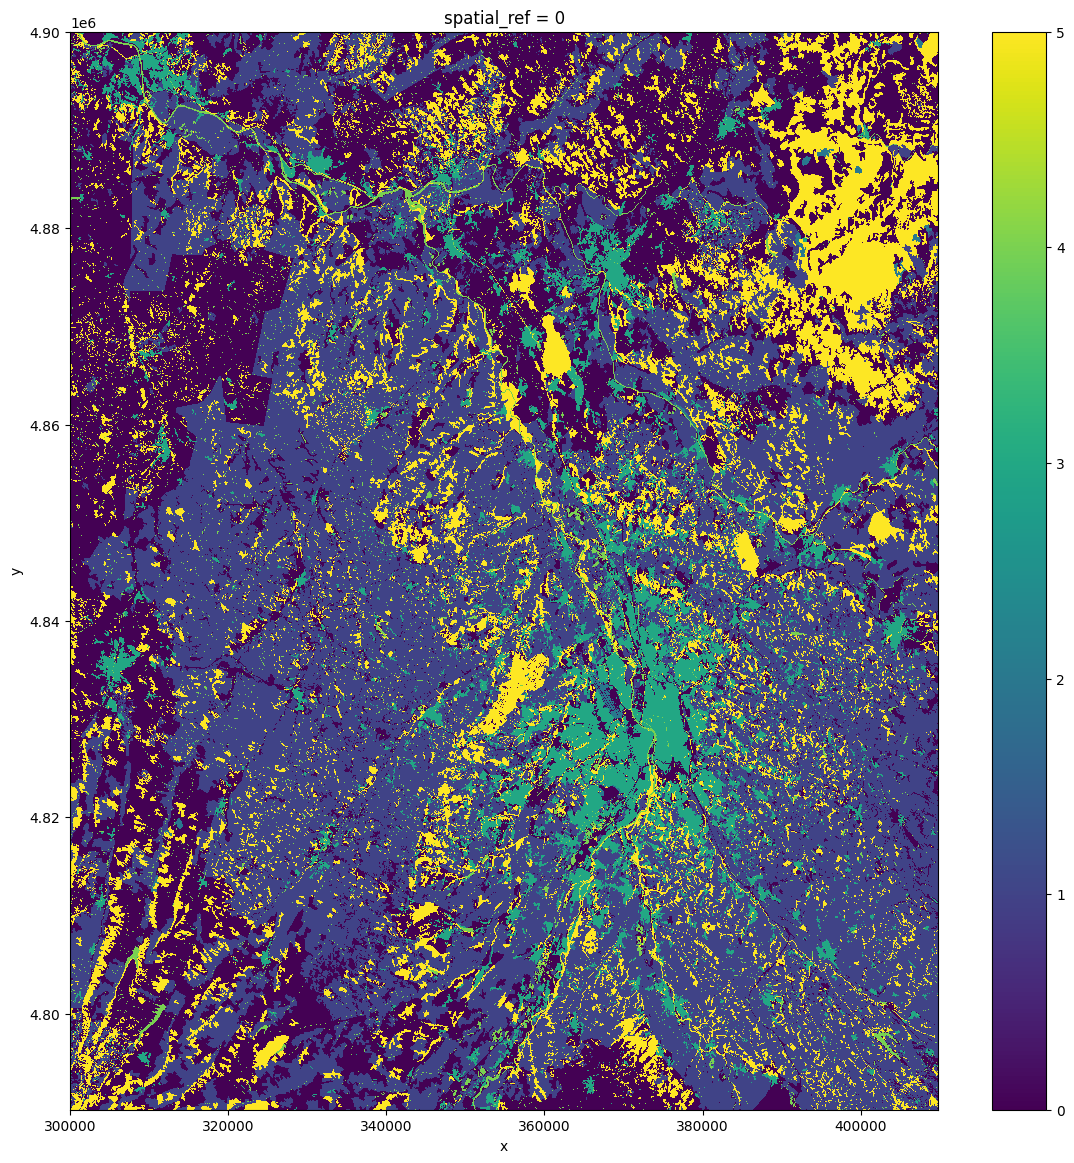

In [66]:
mask = create_groundtruth_classes_mask(ds, osm_gdf, label_id_map=label_id_map)
ax = mask.plot.imshow(figsize=(14, 14))

In [ ]:
# plt.cla()
# plt.clf()

# (ds.sel(band="swir", x=slice(None,None,10), y=slice(None,None,10)) / 10_000).plot.imshow()
# plt.show()

In [68]:
create_label_id_map(osm_gdf)

{'unknown': 0,
 'grassland': 1,
 'urban': 2,
 'farmland': 3,
 'water': 4,
 'forest': 5}

In [69]:
def create_train_data(
    out_dir: str, 
    img_da: xr.DataArray, 
    cls_da: xr.DataArray, 
    chunk_size: tuple[int] = (512,512),
    delete_folder: bool = False,
) -> None:
    out_dir = Path(out_dir)
    if delete_folder and out_dir.exists():
        shutil.rmtree(str(out_dir))
    print(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    img_dir = (out_dir / "img")
    img_dir.mkdir(parents=True, exist_ok=True)
    cls_dir = (out_dir / "cls")
    cls_dir.mkdir(parents=True, exist_ok=True)
    h,w = img_da.shape[-2:]
    c_h,c_w = chunk_size
    xs = np.linspace(0, w-c_w, (w // c_w) * 2).astype(int)
    xs = list(zip(xs, xs + c_w))
    ys = np.linspace(0, h-c_h, (h // c_h) * 2).astype(int)
    ys = list(zip(ys, ys + c_h))
    for i,((x0,x1),(y0,y1)) in tqdm.tqdm(list(enumerate(product(xs, ys)))):
            raster_filename = f"{i:05d}.tiff"
            (img_da[:, y0:y1, x0:x1] / 10000.0).rio.to_raster(img_dir / raster_filename)
            cls_da[y0:y1, x0:x1].rio.to_raster(cls_dir / raster_filename)
    

In [70]:
create_train_data("../data/s2_data", ds, mask, delete_folder=True)

../data/s2_data


100%|██████████| 1764/1764 [01:04<00:00, 27.49it/s]
